# Travaux Pratiques TP 7
-------------

# TVLA
# Test Vector Leakage Assessment methodology with the Welch's t-test

-------------

### using AES Execution on STM32F303 for power traces acquisition



<img src='images/DoIt.png' style='width: 100px'>

# DO IT YOURSELF

In the following you will have to collect side-channel traces in order to assess if the implementation concerned seems vulnerable or not to side-channel attacks. 

At a first step you will use an open source library to detect or not leakages and then you will implement your own t-test code.

The initial publication dealing with using the Welch's t test for TVLA is the following one in 2008:

<img src='./images/Welch-T-test0.png' style='width: 600px'>

https://csrc.nist.gov/csrc/media/events/non-invasive-attack-testing-workshop/documents/08_goodwill.pdf






<img src='./images/Welch-T-test1.png' style='width: 600px'>

https://eprint.iacr.org/2017/138.pdf


<img src='./images/Welch-T-test2.png' style='width: 600px'>


---

------

First you'll need to select which hardware setup you have. 

You'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`. 
* `SCOPETYPE` is `'OPENADC'` for the CWLite
* `PLATFORM` is the target device, with `'CWLITEARM'`
* `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms. 

For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

The following code will build the firmware for the target.

<img src='./images/DoIt.png' style='width: 100px'>

## INDICATE BELOW IN YOUR NOTEBOOK THE RIGHT PATH TO `Setup_Scripts/Setup_Generic.ipynb` on YOUR MACHINE

In [2]:
%run "../../Jupyter3/chipwhisperer/jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


<img src='./images/DoIt.png' style='width: 100px'>

## SAME: INDICATE BELOW IN YOUR NOTEBOOK THE RIGHT PATH TO `hardware/victims/firmware/simpleserial-aes` on YOUR MACHINE

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../Jupyter3/chipwhisperer/hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

<img src='./images/DoIt.png' style='width: 100px'>

## SAME: INDICATE BELOW IN YOUR NOTEBOOK THE RIGHT PATH TO `hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex` on YOUR MACHINE

In [4]:
cw.program_target(scope, prog, "../../Jupyter3/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6247 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6247 bytes


---------
<img src='./images/DoIt.png' style='width: 100px'>

---------
## Run an AES computation and collect the power trace

In [5]:
import numpy as np
import time

In [6]:
ktp = cw.ktp.Basic()

In [7]:
# Generate plaintext and key for the AES execution
key, plaintext = ktp.next()

# Set the AES key for the target
target.set_key(key)

# Send the plaintext to encrypt
target.simpleserial_write('p', plaintext)

# Define the number of samples to collect into the trace
scope.adc.samples = 5_000

# Arm the scope for trace acquisition
scope.arm()

# Run the AES
ret = scope.capture()
if ret:
    print("Target timed out!")

#Store the result
ciphertext_returned = np.array(target.simpleserial_read('r', 16))

#Store the trace collected
trace = np.array(scope.get_last_trace())

<img src='./images/DoIt.png' style='width: 100px'>

---------

#### Print the plaintext used

In [8]:
plaintext

CWbytearray(b'f7 71 b2 4d 71 0b 9a d7 b0 46 08 44 21 49 9f 41')

#### Print the ciphertext returned by the board

In [9]:
ciphertext_returned

array([ 94, 108, 204,  60,  54, 227,  78, 120, 237, 134, 206, 149, 182,
        72,  30,  80], dtype=uint8)

### Print the points of the trace

* What is the trace length? how many points?



In [10]:
trace

array([ 0.09863281, -0.0703125 , -0.04003906, ..., -0.09765625,
       -0.046875  , -0.03515625])

In [11]:
len(trace)

5000

<img src='./images/DoIt.png' style='width: 100px'>

### Verify the AES computation is correct

In [12]:
import scared

In [13]:
scared.aes.encrypt(np.array(plaintext),np.array(key)) == ciphertext_returned

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

### Other solution

<img src='./images/DoIt.png' style='width: 100px'>

### Plot the AES trace captured

In [14]:
import matplotlib.pylab as plt

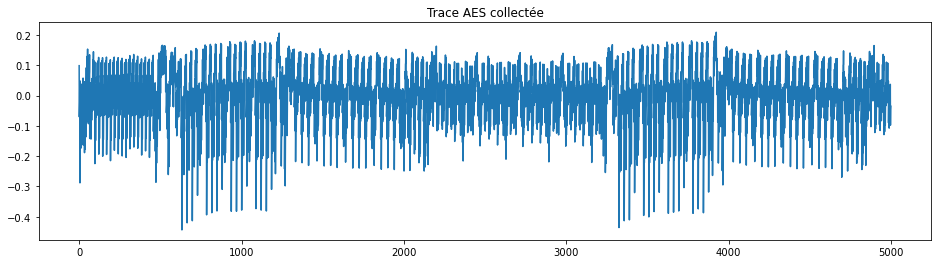

In [15]:
#%matplotlib
plt.rcParams['figure.figsize']=(16,4)
plt.title('Trace AES collectée')
plt.plot(trace)
plt.show()

<img src='./images/DoIt.png' style='width: 100px'>


## Observe the trace 

Open the trace in full screen, zoom and observe

* What do you see?
* What kind of information do you visualize?


---------

<img src='./images/DoIt.png' style='width: 100px'>

## Run several AES executions and collect the corresponding power traces
## Traces Set Collection: 

#### one set with fixed key and random plain text

In [17]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
key, text = ktp.next()
key, text = ktp.next()

target.set_key(key)

scope.adc.samples = 5_000
#scope.adc.samples = 24_000

In [18]:
key1 = key
target.set_key(key1)
key1

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')

In [19]:
key, text = ktp.next()
text

CWbytearray(b'c7 10 f2 ee f8 a4 d8 8e 0e 8c 06 52 73 12 4b d5')

In [24]:
# Number of traces
#N = 500
N = 100

trace_array = []
textin_array = []
keyin_array = []
response_array = []

# Loop for traces collection 
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    keyin_array.append(key)
    response_array.append(response)
    
    key, text = ktp.next() 

/Users/bfeix/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # This is added back by InteractiveShellApp.init_path()


<img src='./images/DoIt.png' style='width: 100px'>


### Plot 10 traces and their first 1000 points

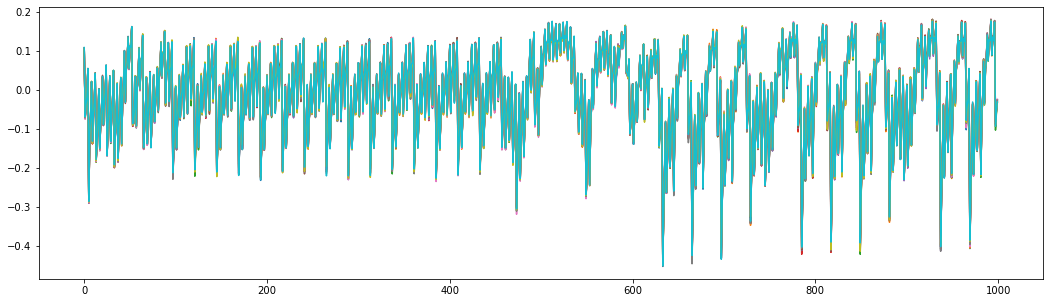

In [25]:
plt.rcParams['figure.figsize']=(18,5)
for i in range(10):
    plt.plot(trace_array[i][0:1000])
plt.show()

### METADATA

In [27]:
textin_array[0:3]

[CWbytearray(b'c7 10 f2 ee f8 a4 d8 8e 0e 8c 06 52 73 12 4b d5'),
 CWbytearray(b'87 97 05 e3 e3 aa 0f 51 81 19 ab c0 e8 2e a0 0f'),
 CWbytearray(b'a1 7e cb 11 43 04 6d 44 2c c2 fa 3d 1b 86 13 fd')]

In [28]:
keyin_array[:3]

[CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c'),
 CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c'),
 CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')]

In [29]:
response_array[:3]

[CWbytearray(b'f3 74 3e 33 99 ac 54 41 1b 9e 5b 89 5f ea 55 e7'),
 CWbytearray(b'0d a8 a3 1a 66 c2 de 78 14 3a 19 bf 17 db 03 99'),
 CWbytearray(b'85 90 0e 6b c0 e4 3e 84 d4 f3 66 e0 c7 5e 95 32')]

In [32]:
ciphertext_np_array = np.array(response_array)
ciphertext_np_array.shape

(100, 16)

In [33]:
key_np_array = np.array(keyin_array)
key_np_array.shape

(100, 16)

In [34]:
traces_np_array = np.array(trace_array)
traces_np_array.shape

(100, 5000)

------------
<img src='./images/DoIt.png' style='width: 100px'>


## Store traces in an ETS file

In [45]:
from estraces import ETSWriter

In [46]:
ths.metadata_tags

['plaintext', 'ciphertext', 'key']

In [ ]:
#out = ETSWriter('TP_7_traces_set_fixKey1_RndPlain.ets', overwrite=True)
#out = ETSWriter('TP_7_traces_set_fixKey1_fixPlain1.ets', overwrite=True)

for i in range(len(ths)): 
    out.write_points(ths[i].samples, index=i)
    out.write_meta(tag='plaintext', metadata=ths[i].plaintext, index=i)
    out.write_meta(tag='ciphertext', metadata=ths[i].ciphertext, index=i)
    out.write_meta(tag='key', metadata=ths[i].key, index=i)
    
#end file
out.close()

In [48]:
#ths = estraces.read_ths_from_ets_file('TP_7_traces_set_fixKey1_RndPlain.ets')
#ths = estraces.read_ths_from_ets_file('TP_7_traces_set_fixKey1_fixPlain1.ets')

print(ths)

Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file TP_7_traces_set_fixKey1_RndPlain2.ets with 100 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8



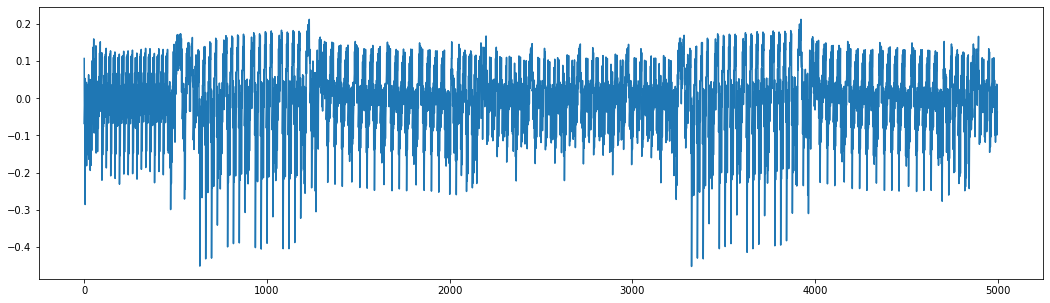

In [49]:
fig, ax = plt.subplots(figsize=(18, 5))
plt.plot(ths[0].samples)
plt.show()

---------

<img src='./images/DoIt.png' style='width: 100px'>

## Same, now do one set with fixed key and fixed plain text

---------------------

<img src='./images/DoIt.png' style='width: 100px'>


# Now perform the Welch t test

## Load traces sets for t test

### Set the container and the T test

#### Plot the T test result

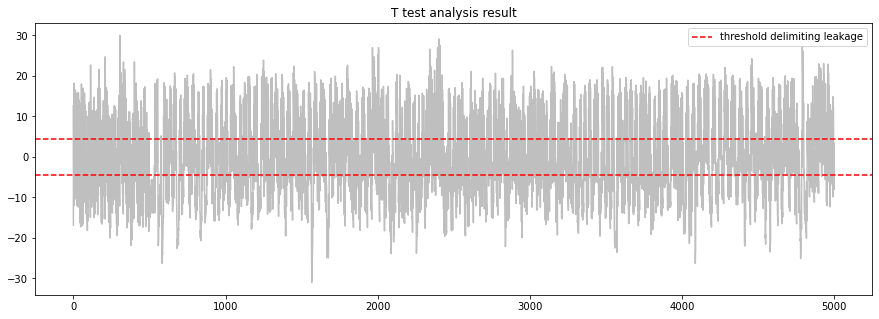

In [145]:
plt.rcParams['figure.figsize']=(15,5)
plt.plot(ttest.result, color='grey', alpha=0.5)
plt.axhline(y=4.5, color='red', linestyle='--', label='threshold delimiting leakage')
plt.axhline(y=-4.5, color='red', linestyle='--')
plt.title('T test analysis result')
plt.legend(loc='upper right')
plt.show()

----------

<img src='./images/DoIt.png' style='width: 100px'>

## DO IT YOURSELF: self implementation of t test

<img src='./images/Welch-T-test2.png' style='width: 600px'>


In [ ]:
path_fixed1 = "../SideSCA-Traces-Public/TP_7_traces_set_fixKey1_fixPlain1.ets"
path_random1 = "../SideSCA-Traces-Public/TP_7_traces_set_fixKey1_RndPlain.ets"

In [176]:
ths_fixed1 = estraces.read_ths_from_ets_file(path_fixed1)
ths_random1 = estraces.read_ths_from_ets_file(path_random1)

In [177]:
nb_traces = 100
ths_0=ths_fixed2[:nb_traces]
ths_1=ths_random1[:nb_traces]

In [178]:
from tqdm import tnrange
import numpy as np

In [179]:
import matplotlib.pyplot as plt

In [180]:
plt.rcParams['figure.figsize']=(15,3)

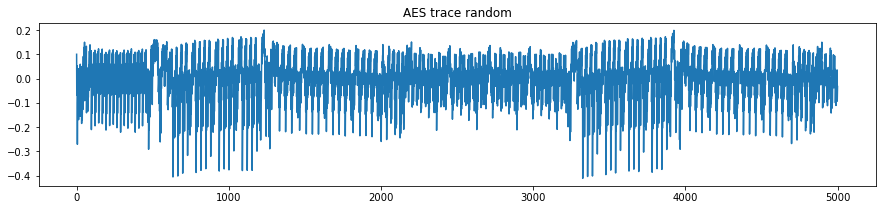

In [181]:
plt.plot(ths_1.samples[0:1].T)
plt.title('AES trace random')
plt.show()

Questions:
* What could be the issues with this implementation?

For instance here you have 100 traces of 5000 points in each trace. 

What is the size of one trace?
https://numpy.org/doc/stable/reference/arrays.dtypes.html

https://www.pythoninformer.com/python-libraries/numpy/data-types/


### Now consider in real life I will be attacking 5 millions traces of 50_000 np.float64 points

